In [ ]:
# %pip install langchain
# %pip install pydantic
# %pip install fastapi
# %pip install -U langchain-community
# %pip install transformers

import pandas as pd
from fastapi import FastAPI
from pydantic import BaseModel
from datetime import datetime
import json
import os

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferWindowMemory


from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

  Using cached transformers-4.52.1-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.31.4-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.11.6-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)
Using cached transformers-4.52.1-py3-none-any.whl (10.5 MB)
Using cached huggingface_hub-0.31.4-py3-none-any.whl (489 kB)
Using cached regex-2024.11.6-cp313-cp313-win_amd64.whl (273 kB)
Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl (308 kB)
Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl (2.4 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached fsspec-2025.5.0-py3-none-any.whl (196 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\amolc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [16]:
df = pd.read_csv("multi_domain_chatbot_dataset_with_intents.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            6000 non-null   int64 
 1   Domain        6000 non-null   object
 2   User Input    6000 non-null   object
 3   Bot Response  6000 non-null   object
 4   Context ID    6000 non-null   int64 
 5   Context       5998 non-null   object
 6   Intent        6000 non-null   object
dtypes: int64(2), object(5)
memory usage: 328.3+ KB


In [17]:
df.head()

,ID,Domain,User Input,Bot Response,Context ID,Context,Intent
0,1420,Finance,How do I get a bank statement?,You can download it from your online banking p...,1419,Can I invest in stocks through your bank?,get_bank_statement
1,809,E-commerce,I forgot my account password.,Click on 'Forgot Password' to reset it.,808,What payment methods do you accept?,reset_password
2,1494,E-commerce,What is the refund policy?,You can get a full refund within 30 days of pu...,1493,Can I cancel my order?,ask_refund_policy
3,1340,E-commerce,Can I get a gift receipt?,"Yes, we offer gift receipts during checkout.",1339,I forgot my account password.,request_gift_receipt
4,2219,Finance,Can I invest in stocks through your bank?,"Yes, we offer stock investment services.",2218,What documents are needed for a home loan?,stock_investment


In [18]:
df.drop(columns=["ID", "Context ID"], inplace=True)
df.head()

,Domain,User Input,Bot Response,Context,Intent
0,Finance,How do I get a bank statement?,You can download it from your online banking p...,Can I invest in stocks through your bank?,get_bank_statement
1,E-commerce,I forgot my account password.,Click on 'Forgot Password' to reset it.,What payment methods do you accept?,reset_password
2,E-commerce,What is the refund policy?,You can get a full refund within 30 days of pu...,Can I cancel my order?,ask_refund_policy
3,E-commerce,Can I get a gift receipt?,"Yes, we offer gift receipts during checkout.",I forgot my account password.,request_gift_receipt
4,Finance,Can I invest in stocks through your bank?,"Yes, we offer stock investment services.",What documents are needed for a home loan?,stock_investment


In [20]:
# Get unique values and their count for each column
for column in ["Domain", "Intent"]:
    print(f"Column: {column}")
    print(f"Unique values: {df[column].nunique()}")
    print(f"Values: {df[column].unique()}")
    print()

Column: Domain
Unique values: 2
Values: ['Finance' 'E-commerce']

Column: Intent
Unique values: 19
Values: ['get_bank_statement' 'reset_password' 'ask_refund_policy'
 'request_gift_receipt' 'stock_investment' 'cancel_order'
 'ask_interest_rate' 'loan_prepayment_fee' 'apply_loan' 'update_address'
 'ask_credit_score' 'track_order' 'home_loan_documents'
 'report_damaged_item' 'ask_shipping_info' 'ask_investment_info'
 'initiate_return' 'open_account' 'ask_payment_options']



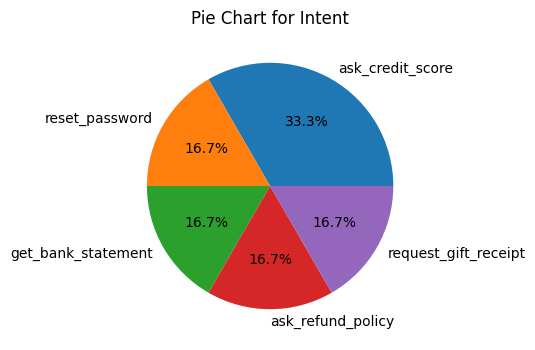

In [24]:
import matplotlib.pyplot as plt

# Plot pie chart for each column
for column in ["Intent"]:
    # Get the top 5 unique values
    top_values = df[column].value_counts().nlargest(5)
    
    # Plot pie chart
    plt.figure(figsize=(5, 4))
    plt.pie(top_values, labels=top_values.index, autopct='%1.1f%%')
    plt.title(f"Pie Chart for {column}")
    plt.show()

In [25]:
print("Initial shape:", df.shape)
print("Missing values:\n", df.isnull().sum())

Initial shape: (6000, 5)
Missing values:
 Domain          0
User Input      0
Bot Response    0
Context         2
Intent          0
dtype: int64


In [26]:
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)

Shape after removing duplicates: (22, 5)


In [27]:
# 3. Strip whitespace and lowercase text fields
text_columns = ['Domain', 'User Input', 'Bot Response', 'Context', 'Intent']
for col in text_columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

In [31]:
df.head(5)

,Domain,User Input,Bot Response,Context,Intent
0,finance,how do i get a bank statement?,you can download it from your online banking p...,can i invest in stocks through your bank?,get_bank_statement
1,e-commerce,i forgot my account password.,click on 'forgot password' to reset it.,what payment methods do you accept?,reset_password
2,e-commerce,what is the refund policy?,you can get a full refund within 30 days of pu...,can i cancel my order?,ask_refund_policy
3,e-commerce,can i get a gift receipt?,"yes, we offer gift receipts during checkout.",i forgot my account password.,request_gift_receipt
4,finance,can i invest in stocks through your bank?,"yes, we offer stock investment services.",what documents are needed for a home loan?,stock_investment


In [34]:
# 4. Remove special characters and extra spaces from text
import re
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()

In [35]:
for col in ['User Input', 'Context']:
    df[col] = df[col].apply(clean_text)

In [36]:
# 5. Check for any remaining issues
print("Null values after cleaning:\n", df.isnull().sum())
print("Sample cleaned data:\n", df.head())

Null values after cleaning:
 Domain          0
User Input      0
Bot Response    0
Context         0
Intent          0
dtype: int64
Sample cleaned data:
        Domain                                User Input  \
0     finance             how do i get a bank statement   
1  e-commerce              i forgot my account password   
2  e-commerce                 what is the refund policy   
3  e-commerce                  can i get a gift receipt   
4     finance  can i invest in stocks through your bank   

                                        Bot Response  \
0  you can download it from your online banking p...   
1            click on 'forgot password' to reset it.   
2  you can get a full refund within 30 days of pu...   
3       yes, we offer gift receipts during checkout.   
4           yes, we offer stock investment services.   

                                     Context                Intent  
0   can i invest in stocks through your bank    get_bank_statement  
1         what p

In [37]:
# 6. Optional: Encode categorical features (e.g., Domain, Intent)
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in ['Domain', 'Intent']:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached scipy-1.15.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -----------------------

In [38]:
df.to_csv("cleaned_chatbot_dataset.csv", index=False)
print("Cleaned dataset saved as 'cleaned_chatbot_dataset.csv'")

Cleaned dataset saved as 'cleaned_chatbot_dataset.csv'


In [39]:
df.head()

,Domain,User Input,Bot Response,Context,Intent,Domain_encoded,Intent_encoded
0,finance,how do i get a bank statement,you can download it from your online banking p...,can i invest in stocks through your bank,get_bank_statement,1,8
1,e-commerce,i forgot my account password,click on 'forgot password' to reset it.,what payment methods do you accept,reset_password,0,15
2,e-commerce,what is the refund policy,you can get a full refund within 30 days of pu...,can i cancel my order,ask_refund_policy,0,5
3,e-commerce,can i get a gift receipt,"yes, we offer gift receipts during checkout.",i forgot my account password,request_gift_receipt,0,14
4,finance,can i invest in stocks through your bank,"yes, we offer stock investment services.",what documents are needed for a home loan,stock_investment,1,16
